In [2]:
from datetime import datetime
import itertools
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

from database import data_utils, data_loader
from models import basic_nn

import importlib
importlib.reload(basic_nn)
importlib.reload(data_loader)

<module 'database.data_loader' from '/Users/zack/Desktop/valle/src/database/data_loader.py'>

In [3]:
# Read in train data
kcm_data_train = []
for i in range(0,5):
    kcm_contents = open("../results/kcm2weeks/data/train_0"+str(i), "r").read()
    kcm_data_train.append([json.loads(str(item)) for item in kcm_contents.strip().split('\n')])
kcm_data_train = list(itertools.chain.from_iterable(kcm_data_train))
# Read in test data
kcm_contents = open("../results/kcm2weeks/data/test", "r").read()
kcm_data_valid = [json.loads(str(item)) for item in kcm_contents.strip().split('\n')]

In [27]:
# Set hyperparameters
EPOCHS = 10
BATCH_SIZE = 100
LEARN_RATE = 1e-2

# Make data loaders
dataloader_train = data_loader.make_dataloader(kcm_data_train, BATCH_SIZE)
dataloader_valid = data_loader.make_dataloader(kcm_data_valid, BATCH_SIZE)

# Initialize model
model = basic_nn.BasicNeuralNet(dataloader_train.dataset[0][0].shape[0])
optimizer = torch.optim.Adam(model.parameters(), lr=LEARN_RATE)
loss_fn = torch.nn.MSELoss()
model

BasicNeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=6, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [28]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0
best_vloss = 100000000.

training_loss = []
validation_loss = []
training_steps = len(dataloader_train) // BATCH_SIZE
validation_steps = len(dataloader_valid) // BATCH_SIZE

for epoch in range(EPOCHS):
    print(f'EPOCH: {epoch_number}')

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    running_tloss = 0.0
    last_loss = 0.0

    # Iterate overa all batches per-epoch
    for i, data in enumerate(dataloader_train):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Run forward/backward
        optimizer.zero_grad()
        preds = model(inputs)
        loss = loss_fn(preds, labels.unsqueeze(1))
        loss.backward()

        # Adjust weights
        optimizer.step()

        # Gather data and report
        running_tloss += loss.item()

    # We don't need gradients on to do reporting
    model.train(False)

    avg_batch_loss = running_tloss / training_steps
    training_loss.append(avg_batch_loss)

    running_vloss = 0.0
    for i, vdata in enumerate(dataloader_valid):
        vinputs, vlabels = vdata
        vpreds = model(vinputs)
        vloss = loss_fn(vpreds, vlabels.unsqueeze(1))
        running_vloss += vloss
    avg_valid_loss = running_vloss / validation_steps
    validation_loss.append(avg_valid_loss.item())

    print(f'LOSS: train {avg_batch_loss} valid {avg_valid_loss}')

    # Track best performance, and save the model's state
    if avg_valid_loss < best_vloss:
        best_vloss = avg_valid_loss
        model_path = f'../results/basic_nn/model_{timestamp}_{epoch_number}'
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH: 0
LOSS: train 145903031.35714287 valid 164244784.0
EPOCH: 1
LOSS: train 139660154.98214287 valid 160366128.0
EPOCH: 2
LOSS: train 138175892.625 valid 161602272.0
EPOCH: 3
LOSS: train 137492751.55357143 valid 166528192.0
EPOCH: 4
LOSS: train 137949954.16964287 valid 159754640.0
EPOCH: 5
LOSS: train 137403181.48214287 valid 161079648.0
EPOCH: 6
LOSS: train 137347714.14285713 valid 163453584.0
EPOCH: 7
LOSS: train 137953919.99107143 valid 161159760.0
EPOCH: 8
LOSS: train 137062110.74776787 valid 163493264.0
EPOCH: 9
LOSS: train 136760758.7767857 valid 160985968.0


<AxesSubplot: xlabel='Epoch', ylabel='value'>

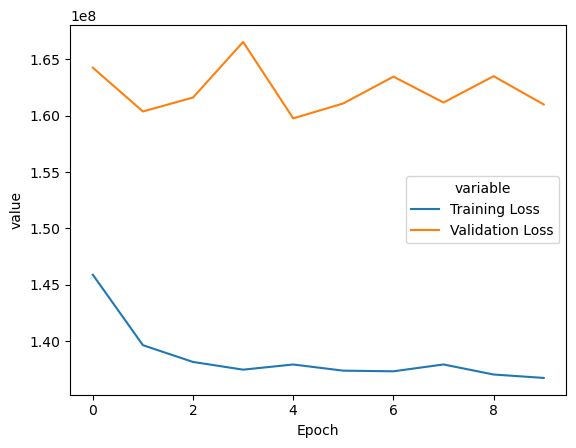

In [32]:
# Plot training curves
plot_data = pd.DataFrame(
    {
        "Epoch": [x for x in range(0,len(training_loss))],
        "Training Loss": training_loss,
        "Validation Loss": validation_loss
    }
)

sns.lineplot(x='Epoch', y='value', hue='variable', data=pd.melt(plot_data, ['Epoch']))